# SF Voter Data Analysis

In this notebook, we'll be taking a look at some voter data from the 2020 election and comparing it to historical data. The focus will be on creating a reusable pipeline to analyze election results.

tl;dr:

Analysis of the 2020 SF Election

Summary:

Candidate 2/B won a total of 31 precincts, receiving almost 15 thousand votes in the 11th Preliminary Report of RCV tabulation. From this analysis, the following insights were gleaned:
    
* In 2016 and 2020, Candidate 2/B won precincts 24, 12,  9, 19, 53, 41, 22, 34, 31, 28, 36, 11, 13,  8, 35, 33, 25,26, 18, 16,  3, 27, 32,  2 both times.
* In 2016 and 2020, Candidate 2/B lost precincts 43, 4, 45, 47, 48, 46, 49 both times.
* Candidate 2/B won 2 additional precincts in 2020 (total went from 29 to 31)
* In Precincts 25 and 11, Candidate 2/B increased their vote count from 2016 to 2020 by 208 and 201 respectively, the highest of all the precinct totals.
* Candidate 2/B won precincts 6,  7, 15, 23, 42, 44, 52 in 2020. Precincts that the candidate lost in 2016.

Tools/Packages Used:

Nothing special, but we developed some new functions specific to analyzing voter/election data. All are reusable and a part of the pipeline.

In [375]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")
%matplotlib inline

We'll start by importing our data. Please keep in mind that due to the nature of the 2020 election, results take a little longer than normal. We'll be using Preliminary Report 11 from the SF Department of Elections website (https://sfelections.sfgov.org/november-3-2020-election-results-detailed-reports). It is possible that these numbers will change as more votes are processed. This data was uploaded to the SF DOE website on 11/10/2020 at 3:46 PM

In [376]:
string2020=r"C:\Users\am513\Desktop\LinkedIn\DataSciPortfolio\2020.csv"
result2020=pd.read_csv(string2020)
result2020.head()

,Precinct,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in
0,1,605,477,38,0,233,214,30,0,0
1,2,1055,836,68,1,348,409,79,0,0
2,3,1017,837,55,4,328,439,70,0,0
3,4,1098,814,88,3,403,336,75,0,0
4,6,833,629,76,0,219,343,67,0,0


You'll notice that this file looks a little different than the Statement of the Vote Excel file that you get from the DOE website. Other than that, the data is 100% the same. There are a couple of reasons for this: 
* The original file isn't friendly for data science
* I want to protect exactly what candidates and contest this data is from

Precinct seems to be the unique key for this data set. Let's double check and make it the index if this is true.

In [377]:
all(result2020["Precinct"])

True

In [378]:
result2020=result2020.set_index("Precinct")
result2020.head()

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in
Precinct,,,,,,,,,
1,605,477,38,0,233,214,30,0,0
2,1055,836,68,1,348,409,79,0,0
3,1017,837,55,4,328,439,70,0,0
4,1098,814,88,3,403,336,75,0,0
6,833,629,76,0,219,343,67,0,0


Let's see who won this contest.

In [379]:
result2020[["Candidate 1","Candidate 2","Candidate 3","Candidate 4","Write-in"]].sum().sort_values(ascending=False)

Candidate 2    14998
Candidate 1    13285
Candidate 3     2712
Write-in          15
Candidate 4       15
dtype: int64

Seems like Candidate 2 won. Congrats! It also seems that Write-In and Candidate 4 have the same tally of votes. It's probable that Candidate 4 is actually a write in candidate. Let's rework this into a function that works regardless of the data.

In [380]:
def who_won(dataframe,cand=[]):
    num_of_cands=len(cand)
    assert (num_of_cands>0),"Please enter the number of candidates. (Must be more than 0)"
    if num_of_cands==1:
        return cand[0]
    if num_of_cands==2:
        return dataframe[[cand[0],cand[1]]].sum().sort_values(ascending=False).index[0]
    if num_of_cands==3:
        return dataframe[[cand[0],cand[1],cand[2]]].sum().sort_values(ascending=False).index[0]
    if num_of_cands==4:
        return dataframe[[cand[0],cand[1],cand[2],cand[3]]].sum().sort_values(ascending=False).index[0]
    if num_of_cands==5:
        return dataframe[[cand[0],cand[1],cand[2],cand[3],cand[4]]].sum().sort_values(ascending=False).index[0]
    if num_of_cands==6:
        return dataframe[[cand[0],cand[1],cand[2],cand[3],cand[4],cand[5]]].sum().sort_values(ascending=False).index[0]
    if num_of_cands==7:
        return dataframe[[cand[0],cand[1],cand[2],cand[3],cand[4],cand[5],cand[6]]].sum().sort_values(ascending=False).index[0]

In [381]:
who_won(dataframe=result2020,cand=["Candidate 1","Candidate 2","Candidate 3","Candidate 4"])

'Candidate 2'

Let's take a look at turn out

In [382]:
result2020[["Registered Voters","Total Votes"]].sum().sort_values(ascending=False)

Registered Voters    41337
Total Votes          31010
dtype: int64

In [383]:
turnout=(result2020[["Registered Voters","Total Votes"]].sum().sort_values(ascending=False)[1]/result2020[["Registered Voters","Total Votes"]].sum().sort_values(ascending=False)[0])*100
np.round(turnout,decimals=2)

75.02

75% turn out isn't horrible, but it is below the SF average of 86% for the 2020 election

# Precinct Analysis

Let's see how our candidates did in each precinct using ```idxmax```

In [384]:
result2020["Who won?"]=result2020[["Candidate 1","Candidate 2", "Candidate 3","Candidate 4"]].idxmax(axis=1)
result2020.head()

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?
Precinct,,,,,,,,,,
1,605,477,38,0,233,214,30,0,0,Candidate 1
2,1055,836,68,1,348,409,79,0,0,Candidate 2
3,1017,837,55,4,328,439,70,0,0,Candidate 2
4,1098,814,88,3,403,336,75,0,0,Candidate 1
6,833,629,76,0,219,343,67,0,0,Candidate 2


In [385]:
result2020["Who won?"].value_counts()

Candidate 2    31
Candidate 1    12
Name: Who won?, dtype: int64

Our winner Candidate 2 won 31 precincts and Candidate 1 won 12 precincts. It seems that Candidate 3 and 4 did not get enough votes to win a precinct.

In [386]:
result2020["Diff"]=result2020["Candidate 2"]-result2020["Candidate 1"]
result2020.head()

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?,Diff
Precinct,,,,,,,,,,,
1,605,477,38,0,233,214,30,0,0,Candidate 1,-19
2,1055,836,68,1,348,409,79,0,0,Candidate 2,61
3,1017,837,55,4,328,439,70,0,0,Candidate 2,111
4,1098,814,88,3,403,336,75,0,0,Candidate 1,-67
6,833,629,76,0,219,343,67,0,0,Candidate 2,124


In [387]:
cand1won=result2020[result2020["Diff"]<0].sort_values("Diff")
cand1won

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?,Diff
Precinct,,,,,,,,,,,
4,1098,814,88,3,403,336,75,0,0,Candidate 1,-67
47,949,732,72,2,363,308,61,0,0,Candidate 1,-55
14,1061,818,67,1,397,353,68,0,0,Candidate 1,-44
46,1160,863,65,5,416,376,70,1,1,Candidate 1,-40
45,940,759,56,2,370,334,55,0,0,Candidate 1,-36
49,1000,781,63,5,381,345,55,0,0,Candidate 1,-36
48,1093,837,78,8,409,377,51,0,0,Candidate 1,-32
29,1148,848,82,4,394,368,86,0,0,Candidate 1,-26
43,1095,827,66,6,385,359,82,1,1,Candidate 1,-26


In [388]:
len(result2020[result2020["Diff"]<0].sort_values("Diff"))

12

Seems like Candidate 2 didn't do so well in the region that contains the precincts labeled 40. Let's do some visualizations further explore this

In [389]:
def stack_data(dataframe,cands=[],index=""):
    stackked=dataframe[cands].stack().reset_index().set_index(index)
    return stackked.rename(columns={"level_1":"Candidate",0:"Number of Votes"})

In [390]:
stack_data(result2020,["Candidate 1","Candidate 2"],"Precinct").head()

,Candidate,Number of Votes
Precinct,,
1,Candidate 1,233
1,Candidate 2,214
2,Candidate 1,348
2,Candidate 2,409
3,Candidate 1,328


In [391]:
stack2020=result2020[["Candidate 1","Candidate 2"]].stack().reset_index().set_index("Precinct")
stack2020.head()

,level_1,0
Precinct,,
1,Candidate 1,233
1,Candidate 2,214
2,Candidate 1,348
2,Candidate 2,409
3,Candidate 1,328


In [392]:
stack2020=stack2020.rename(columns={"level_1":"Candidate",0:"Number of Votes"})
stack2020.head()

,Candidate,Number of Votes
Precinct,,
1,Candidate 1,233
1,Candidate 2,214
2,Candidate 1,348
2,Candidate 2,409
3,Candidate 1,328


In [393]:
result2020.head()

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?,Diff
Precinct,,,,,,,,,,,
1,605,477,38,0,233,214,30,0,0,Candidate 1,-19
2,1055,836,68,1,348,409,79,0,0,Candidate 2,61
3,1017,837,55,4,328,439,70,0,0,Candidate 2,111
4,1098,814,88,3,403,336,75,0,0,Candidate 1,-67
6,833,629,76,0,219,343,67,0,0,Candidate 2,124


Seems like using ```stack``` worked. Now let's visualize

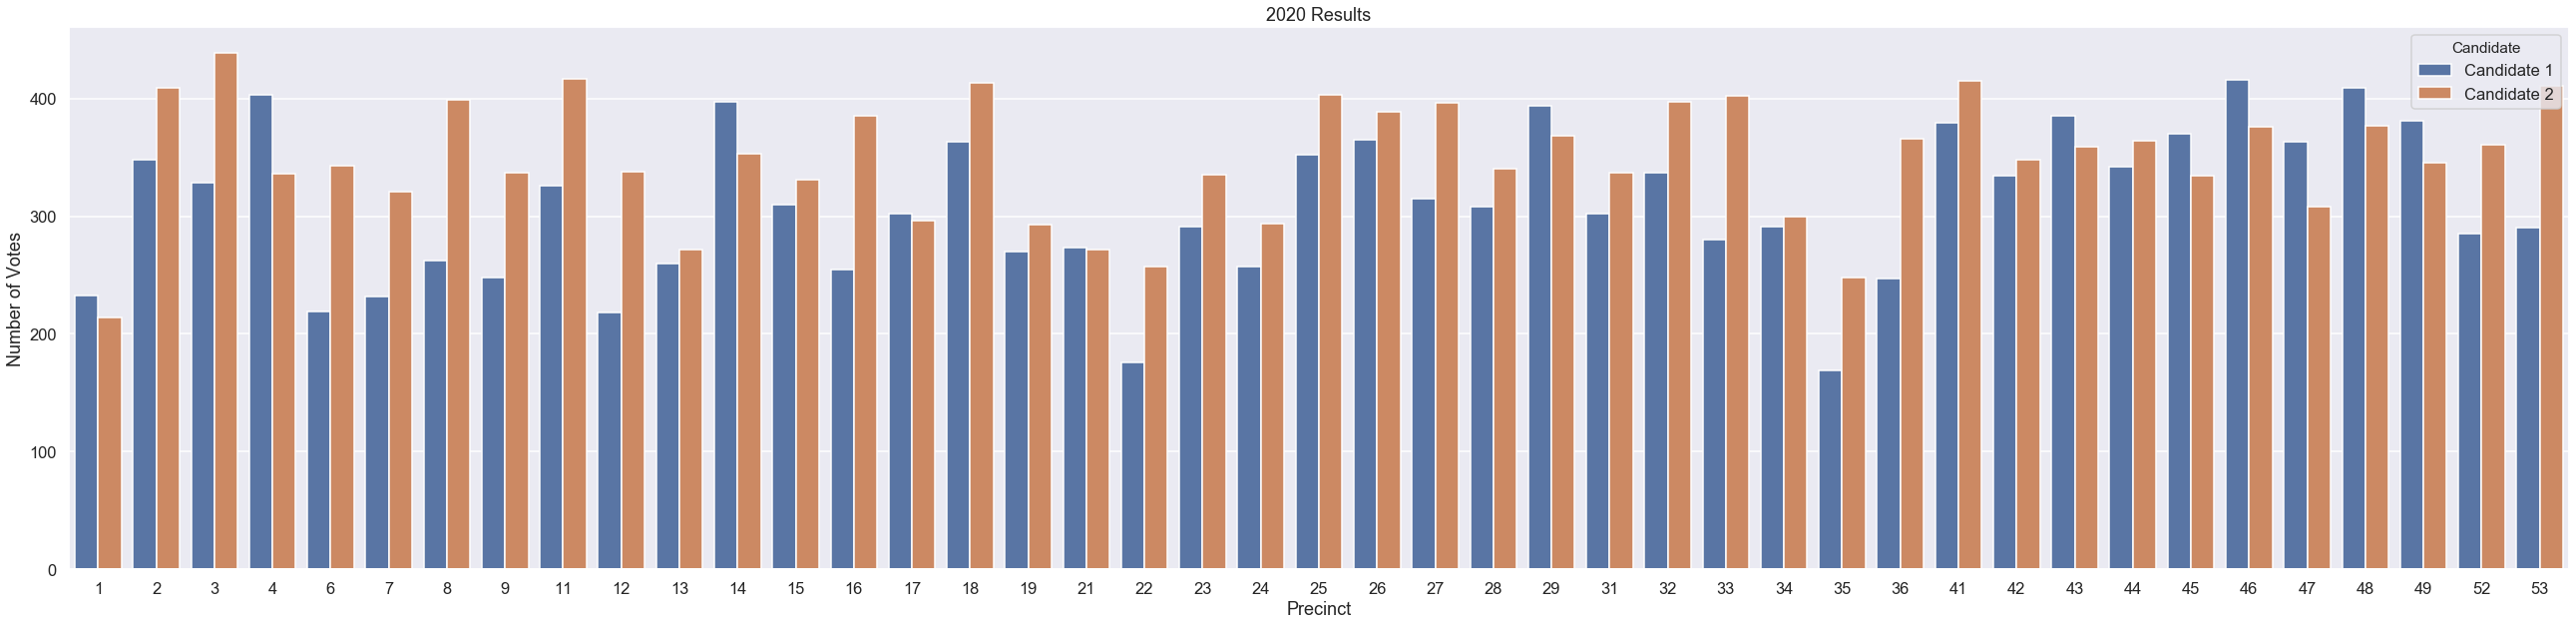

In [394]:
prec=stack2020.index
plt.figure(figsize=(40,10))
sns.barplot(x=prec,y="Number of Votes",hue="Candidate",data=stack2020)
plt.title("2020 Results");

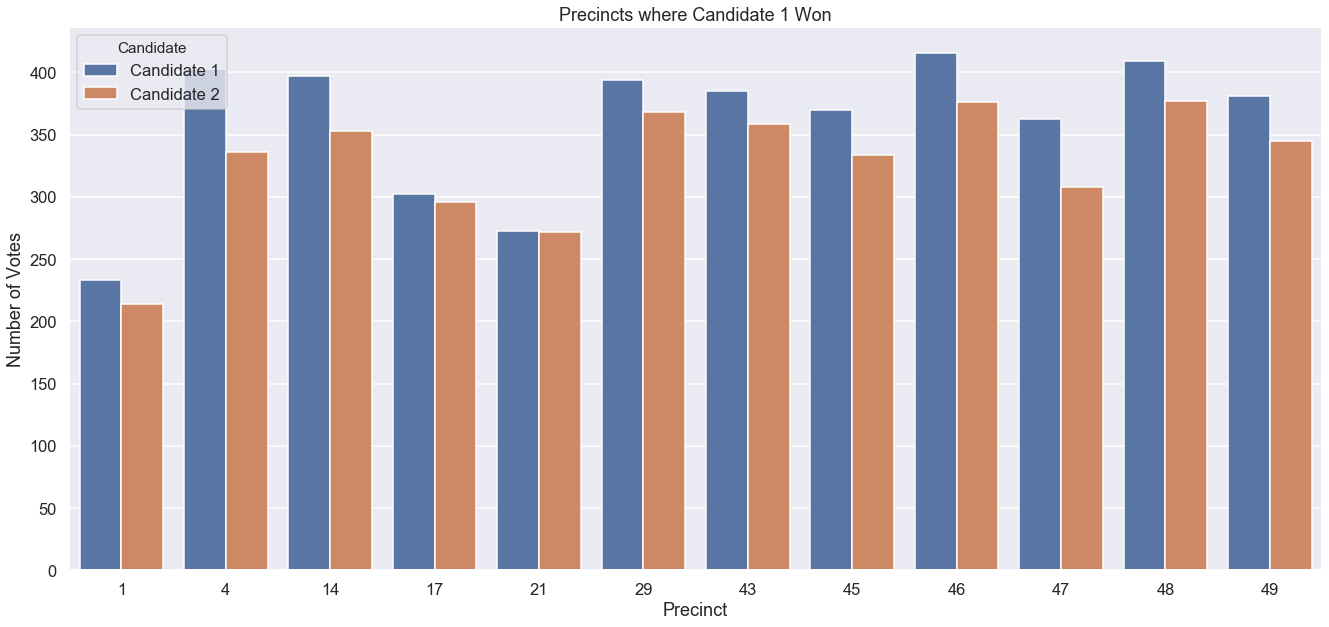

In [395]:
preccand1=cand1won.index

cand12020=stack2020.loc[preccand1]
indexprec=cand12020.index

plt.figure(figsize=(20,10))
sns.barplot(x=indexprec,y="Number of Votes",hue="Candidate",data=cand12020)
plt.title("Precincts where Candidate 1 Won");

Wow! Precinct 21 was only decided by 1 vote! That's razer close (and could change as more votes are processed)

# Comparison to 2016

Now let's do a comparison to the 2016 election. This is gonna be a little funky with the privacy/data adjustments, but the most important thing to remember is **Candidate 2=Candidate B**. No other similarities (A=1, etc.) exist. Again, the data is from the DOE website (https://sfelections.sfgov.org/november-8-2016-election-results-detailed-reports)

In [407]:
string2016=r"C:\Users\am513\Desktop\LinkedIn\DataSciPortfolio\2016.csv"
result2016=pd.read_csv(string2016)
results2016=pd.read_csv(string2016)
result2016.head()

,Precinct,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,ReportingType
0,1,586,159,20,0,4,54,25,5,48,0,Election Day
1,1,586,287,18,0,19,112,21,10,99,0,VBM
2,2,996,291,26,1,26,124,22,11,77,1,Election Day
3,2,996,519,25,2,43,228,41,24,143,3,VBM
4,3,971,263,22,0,22,83,34,15,78,2,Election Day


We'll start off doing a lot of the same analysis and cleaning we did with the 2020 dataset.

In [408]:
results2016=result2016.groupby("Precinct").sum()#.drop(["Registration","Ballots Cast"],axis=1)
results2016.head()

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN
Precinct,,,,,,,,,,
1,1172,446,38,0,23,166,46,15,147,0
2,1992,810,51,3,69,352,63,35,220,4
3,1942,781,56,1,52,305,75,36,236,2
4,1982,763,57,2,69,232,55,39,292,6
6,1616,600,67,3,58,166,63,48,168,2


In [409]:
results2016["Registered Voters"]=result2016["Registration"]
results2016["Total Votes"]=result2016["Ballots Cast"]
results2016.head()

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,Registered Voters,Total Votes
Precinct,,,,,,,,,,,,
1,1172,446,38,0,23,166,46,15,147,0,586,287
2,1992,810,51,3,69,352,63,35,220,4,996,291
3,1942,781,56,1,52,305,75,36,236,2,996,519
4,1982,763,57,2,69,232,55,39,292,6,971,263
6,1616,600,67,3,58,166,63,48,168,2,991,329


In [410]:
who_won(results2016,cand=["Candidate A","Candidate B","Candidate C","Candidate C","Candidate E","WRITE-IN"])

'Candidate B'

In 2016, Candidate B/Candidate 2 won as well.

In [411]:
stack2016=stack_data(results2016,["Candidate B","Candidate E"],"Precinct")
stack2016.head()

,Candidate,Number of Votes
Precinct,,
1,Candidate B,166
1,Candidate E,147
2,Candidate B,352
2,Candidate E,220
3,Candidate B,305


In [412]:
def plot_2_cands(dataframe,year):
    precinctlist=dataframe.index
    plt.figure(figsize=(40,10))
    sns.barplot(x=precinctlist,y="Number of Votes",hue="Candidate",data=dataframe)
    plt.title("{} Results".format(year))
    return plt.show;

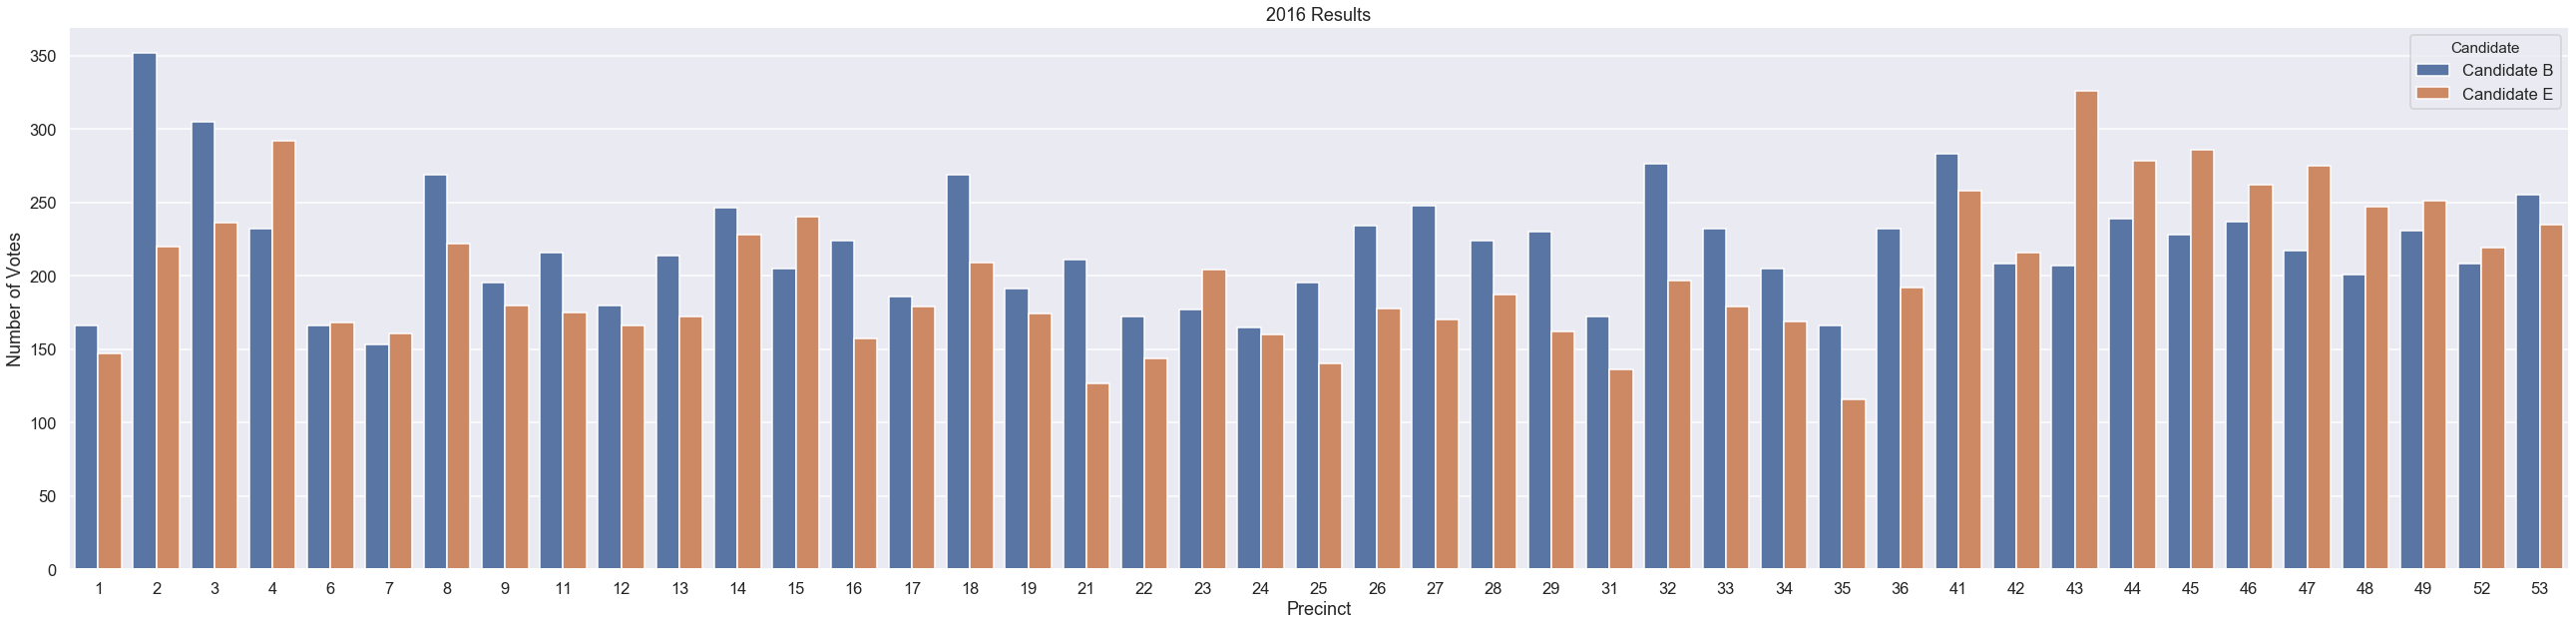

In [413]:
plot_2_cands(stack2016,2016);

In [414]:
def diff(dataframe,cand=[]):
    #cand in position 0 will be subtracted from
    dataframe["Diff"]=dataframe[cand[0]]-dataframe[cand[1]]
    
def num_precinct_lost(dataframe):
    return len(dataframe[dataframe["Diff"]<0].sort_values("Diff"))
    
def precinct_lost(dataframe):
    return dataframe[dataframe["Diff"]<0].sort_values("Diff")
    
def who_won_pct(dataframe,cand=[]):
    dataframe["Who won?"]=dataframe[cand].idxmax(axis=1)

In [415]:
diff(results2016,["Candidate B","Candidate E"])
results2016.head()

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,Registered Voters,Total Votes,Diff
Precinct,,,,,,,,,,,,,
1,1172,446,38,0,23,166,46,15,147,0,586,287,19
2,1992,810,51,3,69,352,63,35,220,4,996,291,132
3,1942,781,56,1,52,305,75,36,236,2,996,519,69
4,1982,763,57,2,69,232,55,39,292,6,971,263,-60
6,1616,600,67,3,58,166,63,48,168,2,991,329,-2


In [416]:
num_precinct_lost(results2016)

14

In [417]:
precinct_lost(results2016)

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,Registered Voters,Total Votes,Diff
Precinct,,,,,,,,,,,,,
43,2112,801,53,4,63,207,75,50,326,2,1029,511,-119
4,1982,763,57,2,69,232,55,39,292,6,971,263,-60
45,1862,753,42,6,56,228,79,31,286,3,954,447,-58
47,1854,734,40,8,75,217,55,44,275,0,911,412,-58
48,1984,727,73,10,58,201,71,50,247,2,907,237,-46
44,1856,713,39,1,50,239,69,24,278,3,954,254,-39
15,1820,746,76,1,58,205,85,45,240,2,809,402,-35
23,1908,646,59,1,70,177,71,38,204,3,971,444,-27
46,2072,791,60,7,84,237,73,52,262,1,911,273,-25


In [418]:
who_won_pct(results2016,cand=["Candidate A","Candidate B","Candidate C","Candidate C","Candidate E","WRITE-IN"])
results2016.head()

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,Registered Voters,Total Votes,Diff,Who won?
Precinct,,,,,,,,,,,,,,
1,1172,446,38,0,23,166,46,15,147,0,586,287,19,Candidate B
2,1992,810,51,3,69,352,63,35,220,4,996,291,132,Candidate B
3,1942,781,56,1,52,305,75,36,236,2,996,519,69,Candidate B
4,1982,763,57,2,69,232,55,39,292,6,971,263,-60,Candidate E
6,1616,600,67,3,58,166,63,48,168,2,991,329,-2,Candidate E


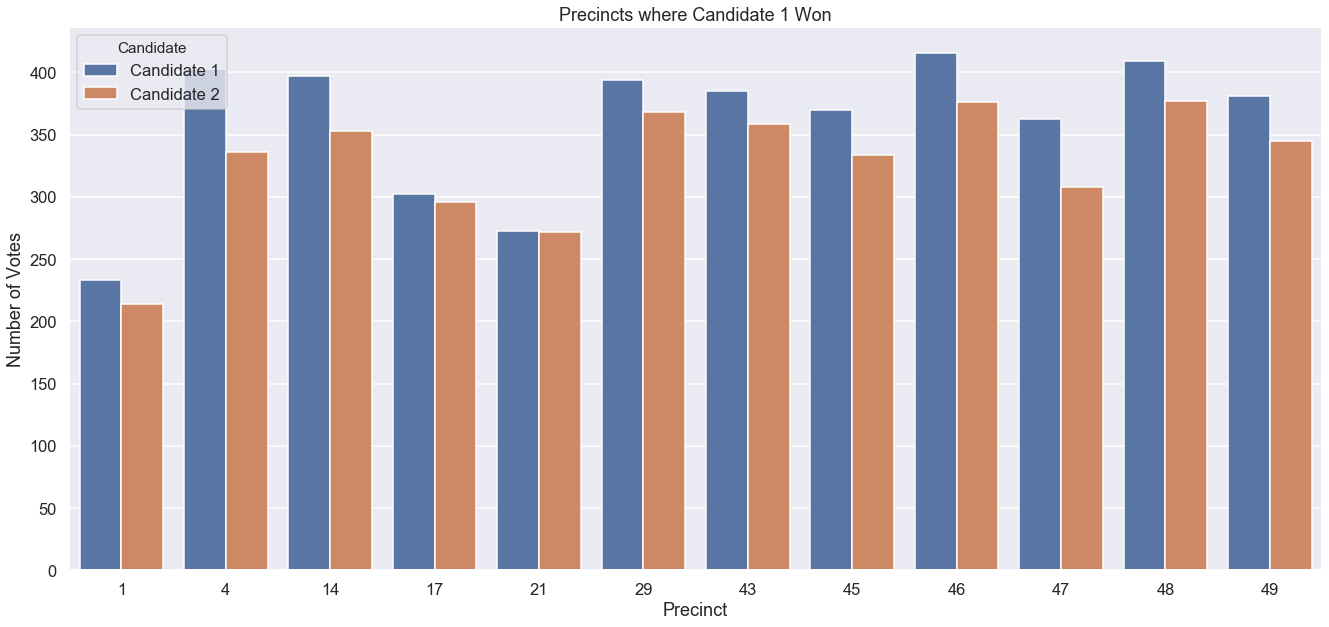

In [419]:
preccand1=cand1won.index

cand12020=stack2020.loc[preccand1]
indexprec=cand12020.index

plt.figure(figsize=(20,10))
sns.barplot(x=indexprec,y="Number of Votes",hue="Candidate",data=cand12020)
plt.title("Precincts where Candidate 1 Won");

In [420]:
def top_2_cands(dataframe,cand=[]):
    lost_precincts=precinct_lost(dataframe).index
    stackdf=stack_data(dataframe,cand,"Precinct")
    pull_lost=stackdf.loc[lost_precincts]
    index_prec=pull_lost.index
    plt.figure(figsize=(20,10))
    sns.barplot(x=index_prec,y="Number of Votes",hue="Candidate",data=pull_lost)
    plt.title("Precincts where {} Won".format(cand[1]))
    return plt.show;

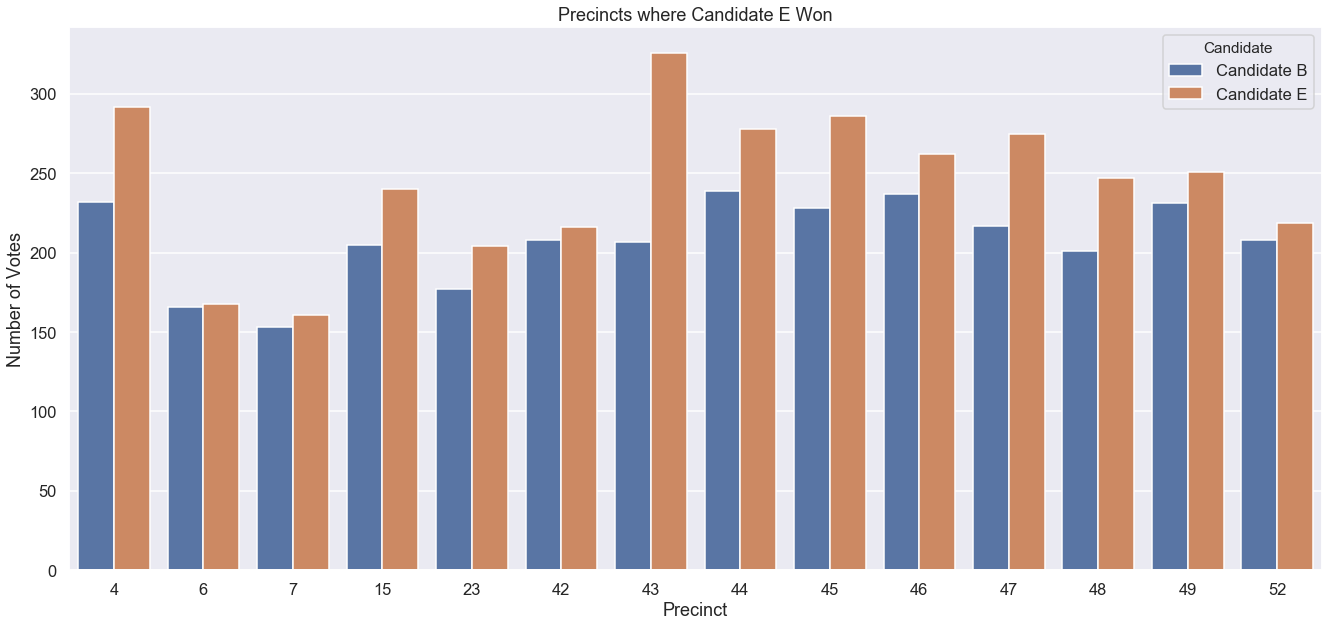

In [421]:
top_2_cands(results2016,["Candidate B","Candidate E"]);

Similar to 2020, the precincts labeled 40 also did not vote for Candidate 2/B in 2016.

In [422]:
def num_precinct_won(dataframe):
    return len(dataframe[dataframe["Diff"]>0].sort_values("Diff"))
    
def precinct_won(dataframe):
    return dataframe[dataframe["Diff"]>0].sort_values("Diff")

In both elections, Candidate 2/B lost these precincts.

In [423]:
precinct_lost(results2016).index&precinct_lost(result2020).index

Int64Index([43, 4, 45, 47, 48, 46, 49], dtype='int64', name='Precinct')

In both elections, Candidate 2/B won these precincts.

In [424]:
precinct_won(results2016).index&precinct_won(result2020).index

Int64Index([24, 12,  9, 19, 53, 41, 22, 34, 31, 28, 36, 11, 13,  8, 35, 33, 25,
            26, 18, 16,  3, 27, 32,  2],
           dtype='int64', name='Precinct')

In [425]:
precinct_won(result2020).head()

,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?,Diff
Precinct,,,,,,,,,,,
34,843,647,64,3,291,300,55,1,1,Candidate 2,9
13,838,603,67,1,260,272,71,0,0,Candidate 2,12
42,981,745,72,2,334,348,63,0,0,Candidate 2,14
15,985,723,79,2,310,331,82,0,0,Candidate 2,21
44,1014,790,60,2,342,364,84,0,0,Candidate 2,22


In [426]:
precinct_won(results2016).head()

,Registration,Ballots Cast,Under Vote,Over Vote,Candidate A,Candidate B,Candidate C,Candidate D,Candidate E,WRITE-IN,Registered Voters,Total Votes,Diff,Who won?
Precinct,,,,,,,,,,,,,,
24,1662,556,42,3,66,165,67,36,160,0,910,233,5,Candidate B
17,1772,644,56,3,60,186,84,41,179,6,1031,471,7,Candidate B
12,1530,557,57,3,53,180,46,28,166,3,951,250,14,Candidate B
9,1618,617,66,4,47,195,59,38,180,5,808,383,15,Candidate B
19,1566,587,55,5,60,191,45,40,174,4,765,384,17,Candidate B


In [427]:
sum(result2020["Candidate 2"])

14998

In [428]:
sum(results2016["Candidate B"])

9422

That's a big difference! Let's see why.

The large gap is because the 2016 data is from round 1 of the ranked choice vote and 2020 isn't. (If you didn't know, San Francisco has ranked choice voting. If you don't know what that is, check it out here: https://sfelections.sfgov.org/ranked-choice-voting) This is just an artifact of the data from DOE and unfortunately, there isn't anything that can be done about it.

# Comparison to 2008

Now, we'll take a look at 2008. This time, we'll just look at the data of Candidate 1 and Candidate 2 (both ran against each other in 2008 and 2020). Data is from DOE (https://sfelections.sfgov.org/election-summary-november-4-2008)

**IMPORTANT NOTE**: Due to redistricting in 2010, the Precincts in 2008 do not 100% match up to 2016 or 2020

In [431]:
string2008=r"C:\Users\am513\Desktop\LinkedIn\DataSciPortfolio\2008.csv"
result2008=pd.read_csv(string2008)

result2008.head()

,Precinct,Candidate 1,Candidate 2
0,1.0,103.0,69.0
1,1.0,75.0,92.0
2,2.0,99.0,156.0
3,2.0,94.0,154.0
4,3.0,99.0,76.0


In [432]:
result2008=result2008.groupby("Precinct").sum()
result2008=result2008.astype("int64")

In [433]:
stack_data(result2008,["Candidate 1","Candidate 2"],"Precinct").head()

,Candidate,Number of Votes
Precinct,,
1.0,Candidate 1,178
1.0,Candidate 2,161
2.0,Candidate 1,193
2.0,Candidate 2,310
3.0,Candidate 1,165


In [434]:
def diff(dataframe,cand=[]):
    #cand in position 0 will be subtracted from
    dataframe["Diff"]=dataframe[cand[0]]-dataframe[cand[1]]
    
def num_precinct_lost(dataframe):
    return len(dataframe[dataframe["Diff"]<0].sort_values("Diff"))
    
def precinct_lost(dataframe):
    return dataframe[dataframe["Diff"]<0].sort_values("Diff")
    
def who_won_pct(dataframe,cand=[]):
    dataframe["Who won?"]=dataframe[cand].idxmax(axis=1)

In [435]:
diff(result2008,["Candidate 1","Candidate 2"])
who_won_pct(result2008,["Candidate 1","Candidate 2"])

In [436]:
print("Candidate 2 lost",num_precinct_lost(result2008),"precincts in 2008")
print("Candidate 2 won",num_precinct_won(result2008),"precincts in 2008")

Candidate 2 lost 16 precincts in 2008
Candidate 2 won 26 precincts in 2008


Candidate 2 won these precincts in 2008, 2016, and 2020

In [437]:
precinct_won(result2008).index&precinct_won(results2016).index&precinct_won(result2020).index

Index([11, 35, 3, 26, 12, 18, 24, 31, 16, 25, 8, 13, 28, 27, 41, 22], dtype='object', name='Precinct')

Candidate 2 lost these precincts in 2008, 2016, 2020

In [438]:
precinct_lost(result2008).index&precinct_lost(results2016).index&precinct_lost(result2020).index

Index([4, 45, 46], dtype='object', name='Precinct')

Candidate 2 lost these precincts in 2008 and 2020

In [439]:
precinct_lost(result2008).index&precinct_lost(result2020).index

Index([4, 29, 21, 14, 45, 46], dtype='object', name='Precinct')

With our most complete data (2016 and 2020), let's take a look at the win/loss.

In [440]:
print("Won",precinct_won(results2016).index&precinct_won(result2020).index)

print("Lost",precinct_lost(results2016).index&precinct_lost(result2020).index)


Won Int64Index([24, 12,  9, 19, 53, 41, 22, 34, 31, 28, 36, 11, 13,  8, 35, 33, 25,
            26, 18, 16,  3, 27, 32,  2],
           dtype='int64', name='Precinct')
Lost Int64Index([43, 4, 45, 47, 48, 46, 49], dtype='int64', name='Precinct')


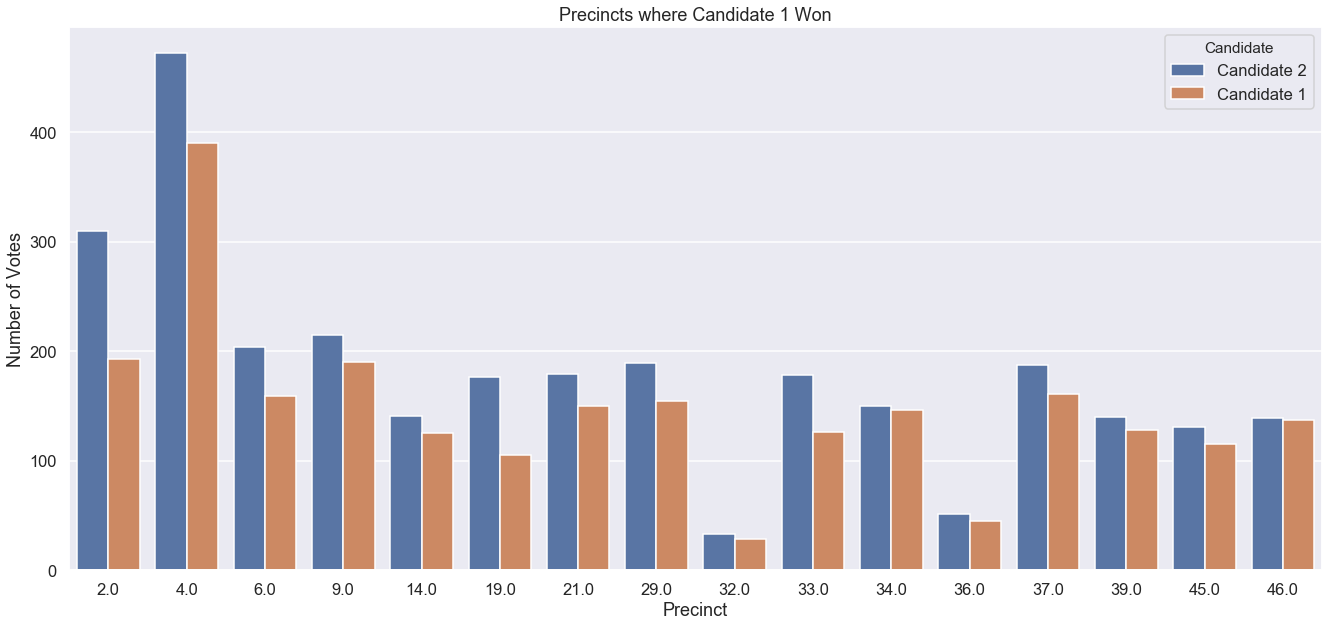

In [441]:
top_2_cands(result2008,["Candidate 2","Candidate 1"]);

# Comparing 2016 and 2020 pt. 2

Let's see how Candidate 2/B did compared to themselves in 2016 and 2020

In [442]:
results2016["Year"]=2016
result2020["Year"]=2020

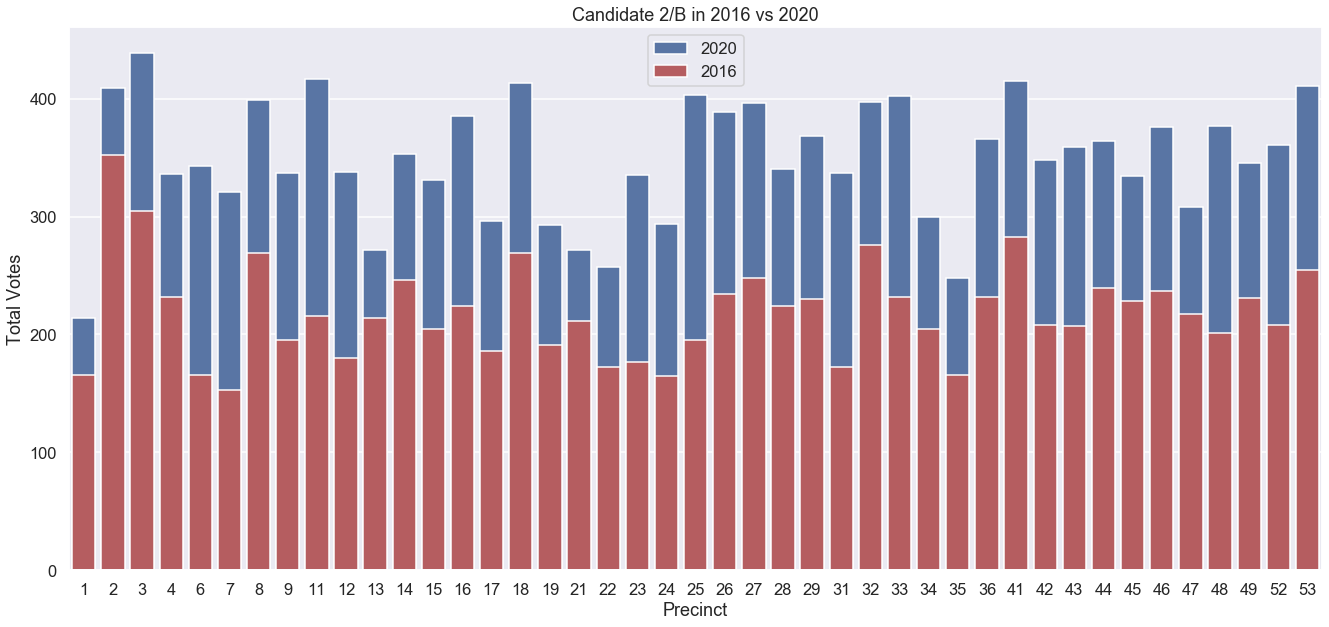

In [443]:
list_of_precincts=results2016.index
cand2_2020=result2020["Candidate 2"]
candb_2016=results2016["Candidate B"]

plt.figure(figsize=(20,10))
sns.barplot(x=list_of_precincts,y=cand2_2020,color="b",label="2020")
sns.barplot(x=list_of_precincts,y=candb_2016,color="r",label="2016")
plt.legend()
plt.title("Candidate 2/B in 2016 vs 2020")
plt.ylabel("Total Votes");

In [444]:
(cand2_2020-candb_2016).idxmax()

25

In [445]:
biggest_change=pd.DataFrame()
biggest_change["Change"]=(cand2_2020-candb_2016)
biggest_change.sort_values(by="Change",ascending=False).head()

,Change
Precinct,
25,208
11,201
6,177
48,176
33,170


In [478]:
copy2020=precinct_won(result2020).copy()
copy2016=precinct_won(results2016).copy()

In [486]:
copy2020["precinct"]=copy2020.index
copy2016["precinct"]=copy2016.index
diff_change=copy2016["precinct"]

In [514]:
print("Precincts won in 2020 but not 2016")
copy2020[~copy2020["precinct"].isin(diff_change)]

Precincts won in 2020 but not 2016


,Registered Voters,Total Votes,Undervotes,Overvotes,Candidate 1,Candidate 2,Candidate 3,Candidate 4,Write-in,Who won?,Diff,Year,precinct
Precinct,,,,,,,,,,,,,
42,981,745,72,2,334,348,63,0,0,Candidate 2,14,2020,42
15,985,723,79,2,310,331,82,0,0,Candidate 2,21,2020,15
44,1014,790,60,2,342,364,84,0,0,Candidate 2,22,2020,44
23,989,695,79,2,291,335,66,3,3,Candidate 2,44,2020,23
52,970,713,63,1,285,361,67,0,0,Candidate 2,76,2020,52
7,805,627,54,2,232,321,74,0,0,Candidate 2,89,2020,7
6,833,629,76,0,219,343,67,0,0,Candidate 2,124,2020,6


In [493]:
num_precinct_won(result2020)-num_precinct_won(results2016)

2

In [499]:
precinct_won(results2016).index

Int64Index([24, 17, 12,  9, 19, 14,  1, 53, 41, 22, 34, 31, 28, 36, 11, 13,  8,
            35, 33, 25, 26, 18, 16, 29,  3, 27, 32, 21,  2],
           dtype='int64', name='Precinct')

In [502]:
np2020=np.array([34, 13, 42, 15, 44, 19, 26, 28, 31, 41, 24, 23, 18, 25, 32,  2, 52,
            35, 22, 27,  9,  7, 11,  3, 36, 12, 53, 33,  6, 16,  8])

In [501]:
np2016=np.array([24, 17, 12,  9, 19, 14,  1, 53, 41, 22, 34, 31, 28, 36, 11, 13,  8,
            35, 33, 25, 26, 18, 16, 29,  3, 27, 32, 21,  2])

Candidate 2/B won these precincts in 2020, but did not win them in 2016.

In [505]:
np.setdiff1d(np2020,np2016)

array([ 6,  7, 15, 23, 42, 44, 52])

In [510]:
result2020[["Candidate 2","Year"]].head()

,Candidate 2,Year
Precinct,,
1,214,2020
2,409,2020
3,439,2020
4,336,2020
6,343,2020


In [512]:
results2016[["Candidate B","Year"]].head()

,Candidate B,Year
Precinct,,
1,166,2016
2,352,2016
3,305,2016
4,232,2016
6,166,2016


In [553]:
copycopy2020=result2020.copy()
copycopy2016=results2016.copy()

In [555]:
copycopy2020["precinct"]=copycopy2020.index
copycopy2016["precinct"]=copycopy2016.index

In [556]:
appendedresult=copycopy2020[["Candidate 2","Year","precinct"]].append(copycopy2016[["Candidate B","Year","precinct"]])

appendedresult.to_csv("comparison.zip",index=False,compression=dict(method="zip",archive_name="comparison.csv"))

In [563]:
stringcomp=r"C:\Users\am513\Desktop\LinkedIn\DataSciPortfolio\comparison.csv"
resultcomp=pd.read_csv(stringcomp)

resultcomp.head()

,Candidate 2/B,Year,precinct
0,214,2020,1
1,409,2020,2
2,439,2020,3
3,336,2020,4
4,343,2020,6


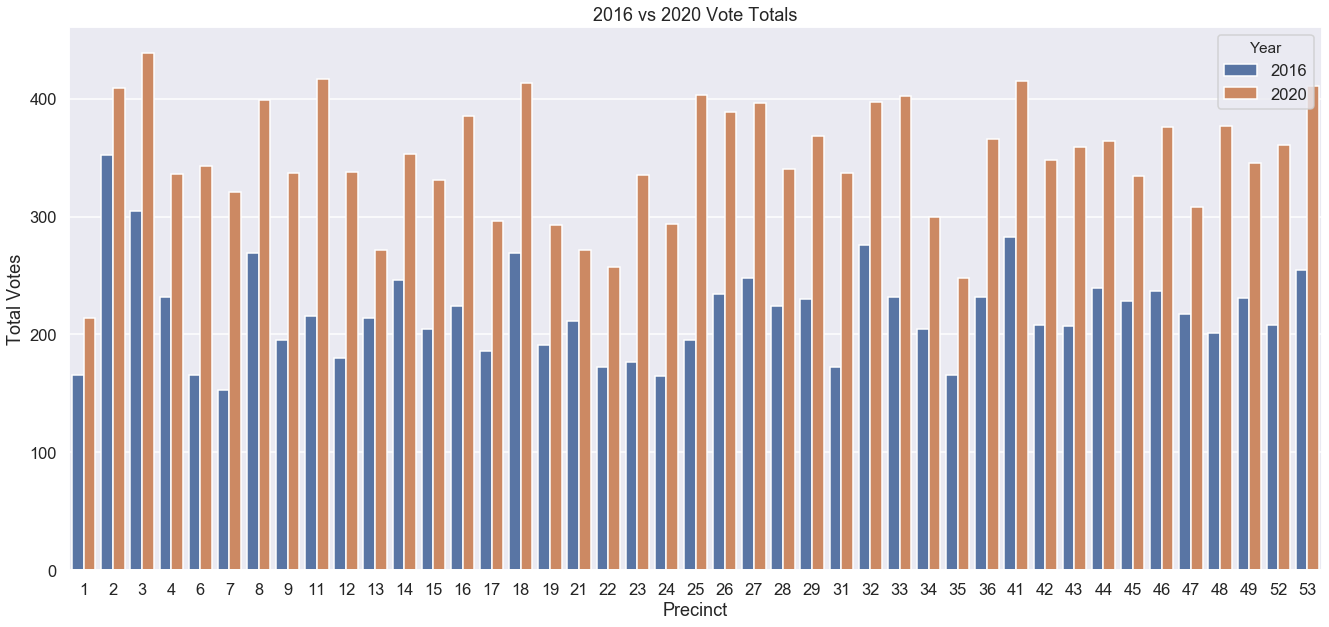

In [565]:
plt.figure(figsize=(20,10))
sns.barplot(x="precinct",y="Candidate 2/B",data=resultcomp,hue="Year")
plt.title("2016 vs 2020 Vote Totals")
plt.xlabel("Precinct")
plt.ylabel("Total Votes");